# NLP for beginners

NLP - natural language processing

One of the most useful application for NLP is classification - classifying a document into some category. <br>
We are gonna use the "US Patent Phrase to Phrase matching competition" for an example <br>
In this, we are tasked with comparing two words or short phrases, and scoring them based on whether they're similar or not, based on which patent class they were used in.

In the original notebook there are instructions on how to get the data from kaggle, but since we do this locally we are gonna skip it

## Import and data overview

In [1]:
import pandas as pd

df = pd.read_csv("CSV/US Patent/train.csv")

In [2]:
df

,id,anchor,target,context,score
0,37d61fd2272659b1,abatement,abatement of pollution,A47,0.50
1,7b9652b17b68b7a4,abatement,act of abating,A47,0.75
2,36d72442aefd8232,abatement,active catalyst,A47,0.25
3,5296b0c19e1ce60e,abatement,eliminating process,A47,0.50
4,54c1e3b9184cb5b6,abatement,forest region,A47,0.00
...,...,...,...,...,...
36468,8e1386cbefd7f245,wood article,wooden article,B44,1.00
36469,42d9e032d1cd3242,wood article,wooden box,B44,0.50
36470,208654ccb9e14fa3,wood article,wooden handle,B44,0.50
36471,756ec035e694722b,wood article,wooden material,B44,0.75


In the competition data section there is a data description, which explains what each column means and etc

In [3]:
df.describe(include="object")

,id,anchor,target,context
count,36473,36473,36473,36473
unique,36473,733,29340,106
top,8d135da0b55b8c88,component composite coating,composition,H01
freq,1,152,24,2186


We can see that in the 36 473 rows, there are 733 unique anchors, 106 contexts, and nearly 30 000 targets. Some anchors are very common, with "component composite coating" for instance appearing 152 times.

The original notebook suggests to represent the input to the model in the form of "TEXT1: {1}; TEXT2: {2}" where 1 is context, 2 is target

In [4]:
df['input'] = "TEXT1: " + df.context + "; TEXT2: " + df.target + "; ANC1: " + df.anchor

In [5]:
df.input.head()

0    TEXT1: A47; TEXT2: abatement of pollution; ANC...
1    TEXT1: A47; TEXT2: act of abating; ANC1: abate...
2    TEXT1: A47; TEXT2: active catalyst; ANC1: abat...
3    TEXT1: A47; TEXT2: eliminating process; ANC1: ...
4    TEXT1: A47; TEXT2: forest region; ANC1: abatement
Name: input, dtype: object

## Tokenization

We are gonna use a transformer, which needs a `Dataset`object. We can create one from a dataFrame

In [6]:
from datasets import Dataset, DatasetDict

dataSet = Dataset.from_pandas(df)

dataSet

Dataset({
    features: ['id', 'anchor', 'target', 'context', 'score', 'input'],
    num_rows: 36473
})

We need to convert the text into numbers, because a deep learning model expects numbers. <br>
We need two things
1. Tokenization - Split each text up into words
2. Numericalization - Convert each text into a number
We are gonna use a model, in particular `microsoft/deberta-v3-small`

In [7]:
modelName = "microsoft/deberta-v3-small"

We are using `AutoTokenizer` to create a tokenizer for the model

In [8]:
from transformers import AutoModelForSequenceClassification,AutoTokenizer
tokz = AutoTokenizer.from_pretrained(modelName, use_fast=False)

Lets see how some examples are converted into tokens

In [9]:
tokz.tokenize("G'day folks, I'm Jeremy from fast.ai!")

['▁G',
 "'",
 'day',
 '▁folks',
 ',',
 '▁I',
 "'",
 'm',
 '▁Jeremy',
 '▁from',
 '▁fast',
 '.',
 'ai',
 '!']

In [10]:
tokz.tokenize("A platypus is an ornithorhynchus anatinus.")

['▁A',
 '▁platypus',
 '▁is',
 '▁an',
 '▁or',
 'ni',
 'tho',
 'rhynch',
 'us',
 '▁an',
 'at',
 'inus',
 '.']

In [11]:
def tok_func(x): return tokz(x["input"])

To make it run quick in parallel we use `map`

In [12]:
tok_ds = dataSet.map(tok_func, batched=True)

Map:   0%|          | 0/36473 [00:00<?, ? examples/s]

This adds new item called `input_ids`. Lets see the first row of the data

In [13]:
row = tok_ds[0]
row['input'], row["input_ids"]

('TEXT1: A47; TEXT2: abatement of pollution; ANC1: abatement',
 [1,
  54453,
  435,
  294,
  336,
  5753,
  346,
  54453,
  445,
  294,
  47284,
  265,
  6435,
  346,
  23702,
  435,
  294,
  47284,
  2])

These ids come from the `vocab` list, which contains a unique integer for every possible token. We can look them up with [''] 

In [14]:
tokz.vocab['▁of']

265

We can see that in the first row there is 265 which corresponds to 'of'

We need to prepare the labels. Transformers assume that labels are pressent in column `labels`, but our dataset has score, so we rename the column

In [15]:
tok_ds = tok_ds.rename_columns({'score': 'labels'})

## Test and validtion sets

We have 2 sets: test.csv and train.csv


In [16]:
eval_df = pd.read_csv('CSV/US Patent/test.csv')
eval_df.describe()

,id,anchor,target,context
count,36,36,36,36
unique,36,34,36,29
top,4112d61851461f60,hybrid bearing,inorganic photoconductor drum,G02
freq,1,2,1,3


### Validation set

To explain why we need training, test and validation sets we are gonna use a math function

In [17]:
def f(x): return -3*x**2 + 2*x + 20

To visualise it we use mathplotlib and some numbers (mathplotlib cannot plot a function just by definition)

In [18]:
import numpy as np
import matplotlib.pyplot as plt

def plot_function(f, min=-2.1, max=2.1, color="r"):
    x = np.linspace(min, max, 100)[:,None]
    plt.plot(x, f(x), color)


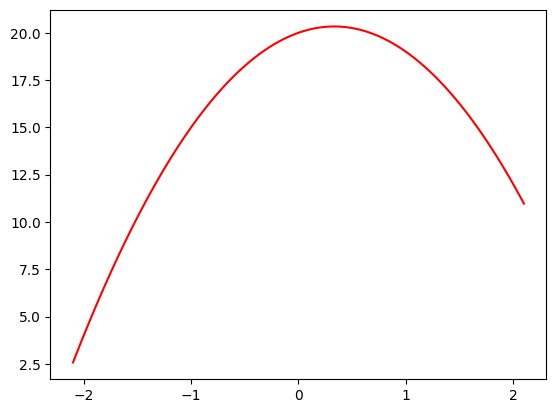

In [19]:
plot_function(f)

Lets add some noise using random number generator

In [20]:
from numpy.random import normal, seed, uniform
np.random.seed(42)

def noise(x, scale): return normal(scale=scale, size=x.shape)
def add_noise(x, mult, add): return x + (1 + noise(x, mult)) + noise(x, add)

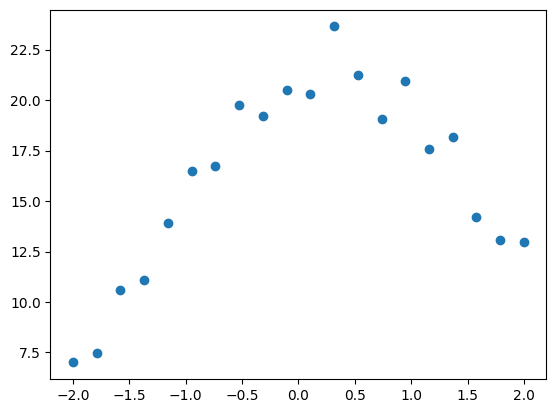

In [21]:
x = np.linspace(-2, 2, num=20)[:, None]
y = add_noise(f(x), 0.2, 1.3)
plt.scatter(x, y)

To see if we *underfit* or *overfit* the predictions, we are gonna use a function that fits a polynomial of some degree. 

In [22]:
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import make_pipeline

def plot_poly(degree):
    model = make_pipeline(PolynomialFeatures(degree), LinearRegression())
    model.fit(x,y)
    plt.scatter(x,y)
    plot_function(model.predict)

Lets see what happens if we fit a line (degree=1)

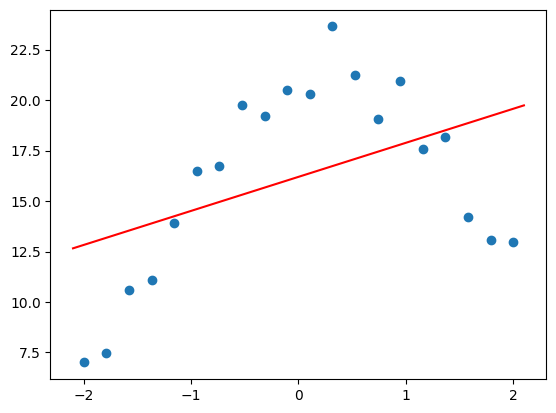

In [23]:
plot_poly(1)

Some points are close(line is fitted) and some aren't. This is *underfit*; not enought detail in our function to match the data <br>
Lets see if we fit a degree 10

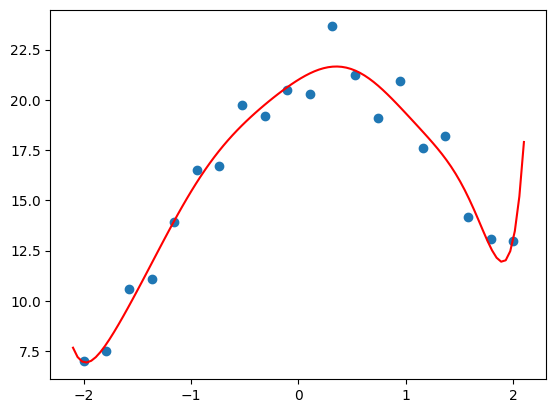

In [24]:
plot_poly(10)

Now it fits better, but it looks like it wont do a great job for other points. This is *overfit*; there is too much details <br>
Lets try a quadratic (degree=2) and compare it to our true function (in blue)

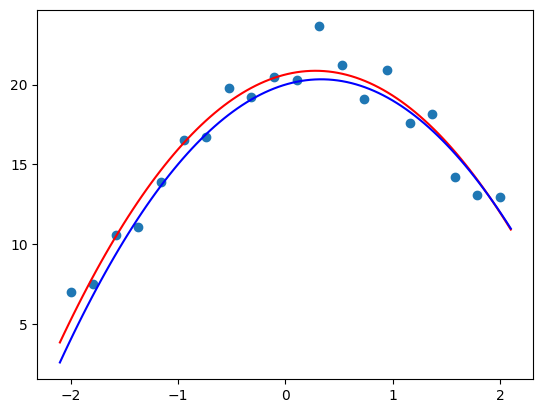

In [25]:
plot_poly(2)
plot_function(f, color="b")

We use a *validation set* to check if a model is underfit or overfit. This set is data which is "hold out" from training. It's only used to see how the model is doing, not as an input.

Transformers uses a `DatasetDict` for training and validation sets. 

In [26]:
dds = tok_ds.train_test_split(0.25, seed=42)
dds

DatasetDict({
    train: Dataset({
        features: ['id', 'anchor', 'target', 'context', 'labels', 'input', 'input_ids', 'token_type_ids', 'attention_mask'],
        num_rows: 27354
    })
    test: Dataset({
        features: ['id', 'anchor', 'target', 'context', 'labels', 'input', 'input_ids', 'token_type_ids', 'attention_mask'],
        num_rows: 9119
    })
})

### Test set

Test set is held out from the model and metric tools. The accuracy of the test set is checked in the end of the training process

We'll use `eval` as name for the test set, to avoid confusion with `test` set in `dds`

In [27]:
eval_df["input"] = "TEXT1: " + eval_df.context + '; TEXT2: ' + eval_df.target + "; ANC1: " + eval_df.anchor
eval_ds = Dataset.from_pandas(eval_df).map(tok_func, batched=True)

Map:   0%|          | 0/36 [00:00<?, ? examples/s]

### Metrics and correlation

In the competition they use pearson correlation coefficient or just r. <br>
r can be betweem -1 and 1, where -1 means inverse correlation and 1 means positive correlation <br>
To understand it we are gonna use the california housing dataset

In [28]:
from sklearn.datasets import fetch_california_housing
housing = fetch_california_housing(as_frame=True)
housing = housing['data'].join(housing['target']).sample(1000, random_state=52)
housing.head()

,MedInc,HouseAge,AveRooms,AveBedrms,Population,AveOccup,Latitude,Longitude,MedHouseVal
7506,3.0550,37.0,5.152778,1.048611,729.0,5.062500,33.92,-118.28,1.054
4720,3.0862,35.0,4.697897,1.055449,1159.0,2.216061,34.05,-118.37,3.453
12888,2.5556,24.0,4.864905,1.129222,1631.0,2.395007,38.66,-121.35,1.057
13344,3.0057,32.0,4.212687,0.936567,1378.0,5.141791,34.05,-117.64,0.969
7173,1.9083,42.0,3.888554,1.039157,1535.0,4.623494,34.05,-118.19,1.192


In [29]:
np.set_printoptions(precision=2, suppress=True)
np.corrcoef(housing, rowvar=False)

array([[ 1.  , -0.12,  0.43, -0.08,  0.01, -0.07, -0.12,  0.04,  0.68],
       [-0.12,  1.  , -0.17, -0.06, -0.31,  0.  ,  0.03, -0.13,  0.12],
       [ 0.43, -0.17,  1.  ,  0.76, -0.09, -0.07,  0.12, -0.03,  0.21],
       [-0.08, -0.06,  0.76,  1.  , -0.08, -0.07,  0.09,  0.  , -0.04],
       [ 0.01, -0.31, -0.09, -0.08,  1.  ,  0.16, -0.15,  0.13,  0.  ],
       [-0.07,  0.  , -0.07, -0.07,  0.16,  1.  , -0.16,  0.17, -0.27],
       [-0.12,  0.03,  0.12,  0.09, -0.15, -0.16,  1.  , -0.93, -0.16],
       [ 0.04, -0.13, -0.03,  0.  ,  0.13,  0.17, -0.93,  1.  , -0.03],
       [ 0.68,  0.12,  0.21, -0.04,  0.  , -0.27, -0.16, -0.03,  1.  ]])

We want only one coeff

In [30]:
np.corrcoef(housing.MedInc, housing.MedHouseVal)

array([[1.  , 0.68],
       [0.68, 1.  ]])

In [31]:
def corr(x,y): return np.corrcoef(x,y)[0][1]

corr(housing.MedInc, housing.MedHouseVal)

np.float64(0.6760250732906004)

We can now look at some examples of correlations using this function

In [32]:
def show_corr(df, a, b):
    x,y = df[a], df[b]
    plt.scatter(x,y,alpha=0.5, s=4)
    plt.title(f"{a} vs {b}; r = {corr(x,y):.2f}")

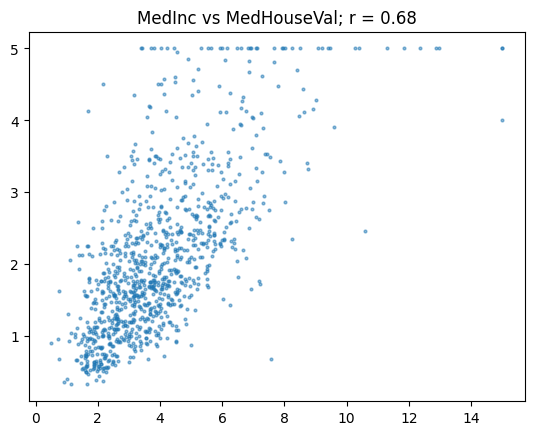

In [33]:
show_corr(housing, 'MedInc', 'MedHouseVal')

Quite a close relationship but still lot of variation

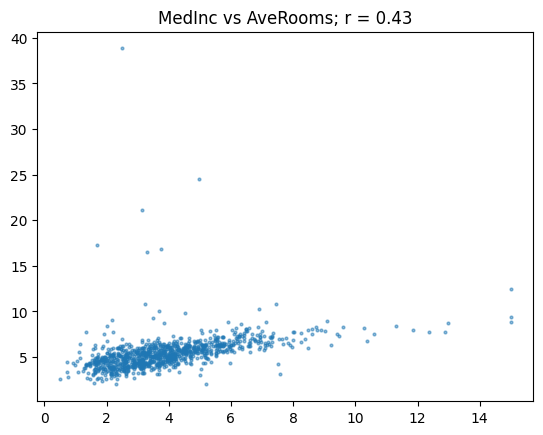

In [34]:
show_corr(housing, 'MedInc', 'AveRooms')

Close relationship like the previous one, but r is lower. The reason is *outliers* - values of `AveRooms` well outside the mean <br>
r is sensitive to outliers. if there are outliers the relationship between them will dominate the metric. <br>
If we remove the outliers we get this

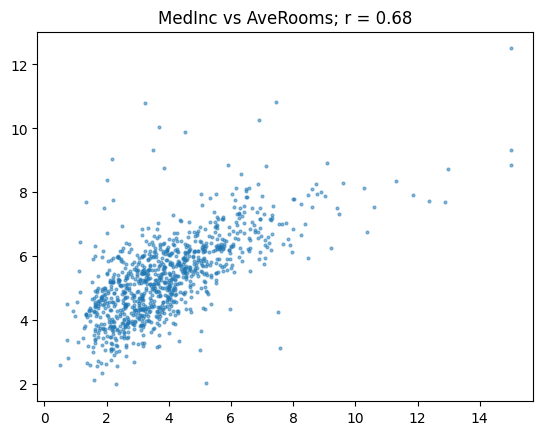

In [35]:
subset = housing[housing.AveRooms<15]
show_corr(subset, 'MedInc', 'AveRooms')

Now the correlation is similar to the first one

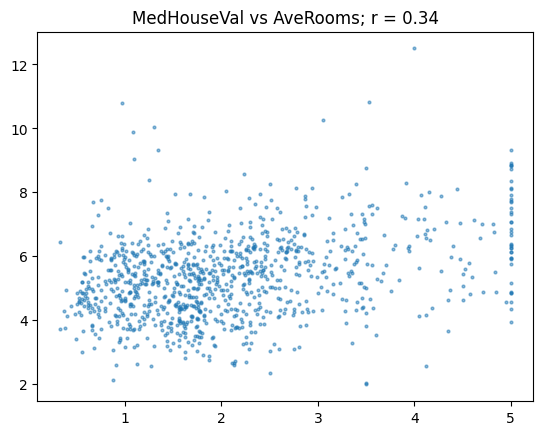

In [36]:
show_corr(subset, 'MedHouseVal', 'AveRooms')

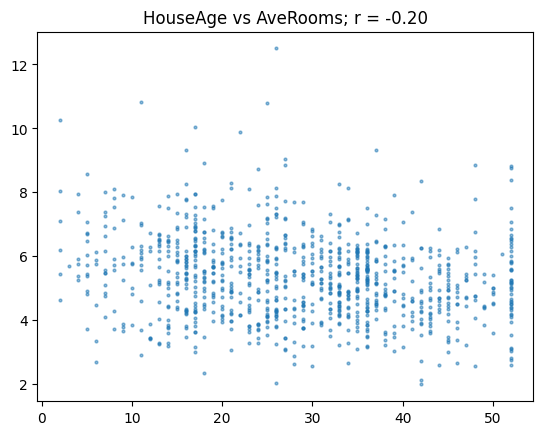

In [37]:
show_corr(subset, 'HouseAge', 'AveRooms')

Correlation of -0.2 shows weak relationship 

Transformers expect metrics to be returned as a `dict`, since that way the trainer knows what label to use.

In [38]:
def corr_d(eval_pred): return {'pearson': corr(*eval_pred)}

## Training

To train it we need a transformer

In [39]:
from transformers import TrainingArguments, Trainer

We pick a batch size (bs) that fits our GPU, and a small number of epocs so we can run experiments quickly

In [40]:
bs = 128
epochs = 4

The most important hyperparameter is `learning rate`. The idea is to find the largest value you can, but which doesn't result in training failing

In [41]:
lr = 8e-5

Transformers use `TrainingArguments` to set up arguments. Most of the values used should generally work in most cases. Its just 3 params that may need to be changed for different models

In [42]:
args = TrainingArguments('outputs', learning_rate = lr, warmup_ratio = 0.1, 
                        lr_scheduler_type='cosine', fp16=True, eval_strategy='epoch',
                        per_device_train_batch_size=bs, per_device_eval_batch_size=bs*2,
                        num_train_epochs=epochs, weight_decay=0.1, report_to='none'
                        )

We can now create a `Trainer` which combines the data and model (in fastai this is a learner)

In [43]:
model = AutoModelForSequenceClassification.from_pretrained(modelName, num_labels=1)

trainer = Trainer(model, args, train_dataset=dds["train"], eval_dataset=dds['test'], tokenizer=tokz, compute_metrics=corr_d)

Some weights of DebertaV2ForSequenceClassification were not initialized from the model checkpoint at microsoft/deberta-v3-small and are newly initialized: ['classifier.bias', 'classifier.weight', 'pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
C:\Users\k.krachmarov\AppData\Local\Temp\ipykernel_30316\3846293522.py:3: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(model, args, train_dataset=dds["train"], eval_dataset=dds['test'], tokenizer=tokz, compute_metrics=corr_d)


The og notebook says ignore warnings (classic programmer)

In [44]:
trainer.train()

Epoch,Training Loss,Validation Loss


KeyboardInterrupt: 